<a href="https://colab.research.google.com/github/TaranDoebe/CIFAR-10/blob/main/CNN_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import confusion_matrix

# Allows charts for plt in colab
%matplotlib inline


In [3]:
# Convert MNIST Image Files into Tensor of 4-Dimensions ( # of Images, Height, Width, Color-Channels)

CIFAR_transform = transforms.ToTensor()

In [40]:
# Train Data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=CIFAR_transform)

In [5]:
# Test Data
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=CIFAR_transform)

In [41]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: /cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
# Create a small batch size for images (10)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [22]:
# Model Class
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)

    # Fully Connected Layers
    self.fc1 = nn.Linear(5 * 5 * 16, 120) # results 2 cells ago == 16 filters, 5x5 pixels - 120 = arbitrary neurons
    self.fc2 = nn.Linear(120, 84) # connect output last_arg,
    self.fc3 = nn.Linear(84, 10) # 120 and 84 same principle. But has to end with 10, because of batch size

  def forward(self, X):
    # First Pass
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2
    # Second Pass
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2) # 2x2 kernel and stride 2

    # Re-View Data to flatten it out
    X = X.view(-1, 16 * 5 * 5) # -1 so we can vary batch size

    # Fully Connected Layers
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return F.log_softmax(X, dim=1)

In [23]:
# Create instance of Model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [24]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.05) # Smaller lr --> Longer train

In [25]:
import time
start_time = time.time()

# Create Variables to Track (opt: graphs)
epochs = 5
# opt
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  train_corr = 0
  test_corr = 0

  # Train
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # Starts batches at 1
    y_pred = model(X_train) # Get predicted values from training set. Not flattened: 2D
    loss = criterion(y_pred, y_train) # compare predicted value with correct value
    predicted = torch.max(y_pred.data, 1)[1] # add number correct predictions indexed of first point
    batch_corr = (predicted == y_train).sum() # How many we got correct from this batch. True = 1, False = 0. Sum.
    train_corr += batch_corr # keep track as we go along in training.

    # Update our params
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out results
    if b%600 == 0:
      print(f'Epoch: {i}, Batch: {b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(train_corr)

  # Test
  with torch.no_grad(): # No gradient so we dont update weights and biases
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      predicted = torch.max(y_val.data, 1)[1] # Adding up correct predictions
      test_corr += (predicted == y_test).sum() # T=1 F=0 and sum away

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)


current_time = time.time()
total = current_time - start_time
print(f'Training took: {total/60} minutes.')

Epoch: 0, Batch: 600, Loss: 2.2680981159210205
Epoch: 0, Batch: 1200, Loss: 0.8767975568771362
Epoch: 0, Batch: 1800, Loss: 0.6301571726799011
Epoch: 0, Batch: 2400, Loss: 0.970734715461731
Epoch: 0, Batch: 3000, Loss: 0.0956183522939682
Epoch: 0, Batch: 3600, Loss: 0.2325334995985031
Epoch: 0, Batch: 4200, Loss: 0.04707902669906616
Epoch: 0, Batch: 4800, Loss: 0.1525276154279709
Epoch: 0, Batch: 5400, Loss: 0.1264665424823761
Epoch: 0, Batch: 6000, Loss: 0.026345884427428246
Epoch: 1, Batch: 600, Loss: 0.010746662504971027
Epoch: 1, Batch: 1200, Loss: 0.08503766357898712
Epoch: 1, Batch: 1800, Loss: 0.012829042971134186
Epoch: 1, Batch: 2400, Loss: 0.014677952043712139
Epoch: 1, Batch: 3000, Loss: 0.18518513441085815
Epoch: 1, Batch: 3600, Loss: 0.13030573725700378
Epoch: 1, Batch: 4200, Loss: 0.21167691051959991
Epoch: 1, Batch: 4800, Loss: 0.010885655879974365
Epoch: 1, Batch: 5400, Loss: 0.00832914374768734
Epoch: 1, Batch: 6000, Loss: 0.3114326596260071
Epoch: 2, Batch: 600, Loss:

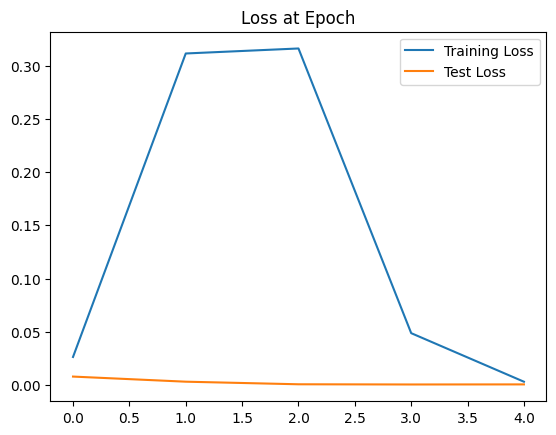

In [26]:
# Graph the loss at each epoch

train_losses = [tl.item() for tl in train_losses]

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title("Loss at Epoch")
plt.legend()

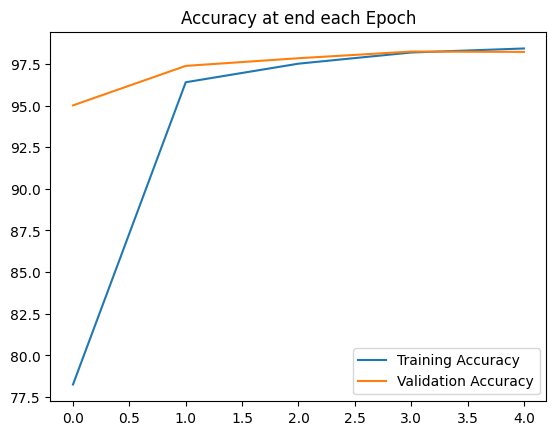

In [27]:
# Graph the accuracy at end each epoch

plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/100 for t in test_correct], label='Validation Accuracy')
plt.title("Accuracy at end each Epoch")
plt.legend()

In [28]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)


In [29]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()

In [30]:
# Test for correct
percent_correct = correct.item()/len(test_data) * 100
print(f'Percent Correct: {percent_correct}')

Percent Correct: 98.22


In [31]:
# Correct items
correct.item()

9822

In [32]:
# Application

# Grab an image
test_data[4143] # Tensor with an image in it, at end it shows label

# In this case its a 9

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [33]:
# easier
test_data[4143][1]

9

In [34]:
# Grab the data
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [35]:
# Reshape it
test_data[4143][0].reshape(28, 28)




tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

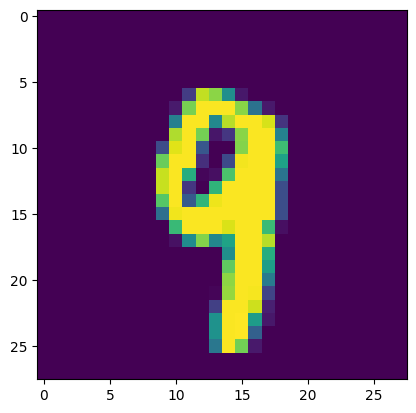

In [36]:
# Show the image

plt.imshow(test_data[4143][0].reshape(28, 28))

In [37]:
# Pass image through model

model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1, 1, 28, 28)) # batch size of 1, 1 color channel, 28 x 28 image

In [38]:
# Check the new prediction, get probabilities of 0,1,2,3,4,5,6,7,8,9
new_prediction

tensor([[-1.7618e+01, -1.4224e+01, -1.9580e+01, -9.0456e+00, -7.8891e+00,
         -1.5659e+01, -2.2071e+01, -1.2179e+01, -9.7594e+00, -5.5667e-04]])

In [39]:
new_prediction.argmax()

tensor(9)